In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tqdm import tqdm
from torch.nn.utils import spectral_norm


/root/miniconda3/envs/myconda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ads = pd.read_csv('train/train_data_ads.csv')
feeds = pd.read_csv('train/train_data_feeds.csv')

## Advertisers  Data Processing

* split list data
* for timestamp data, we transformed it into int type which represents how mant minutes it is from the earliest time.

In [3]:
ads.head()

,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,...,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
0,373250,0,100005,3,2,16,147,2,32,6,...,30157^30648^14278^31706,2066^1776^1036,114^219^312,24107,1218,173,202206030326,39^220^16,0,15
1,373253,1,100005,3,2,16,147,2,32,6,...,30157^30648^14278^31706,2066^1776^1036,114^219^312,24107,1218,173,202206030326,39^220^16,0,15
2,373252,1,100005,3,2,16,147,2,32,6,...,30157^30648^14278^31706,2066^1776^1036,114^219^312,24107,1218,173,202206030326,39^220^16,0,15
3,373251,0,100005,3,2,16,147,2,32,6,...,30157^30648^14278^31706,2066^1776^1036,114^219^312,24107,1218,173,202206030326,39^220^16,0,15
4,373255,0,100005,3,2,16,147,2,32,6,...,30157^30648^14278^31706,2066^1776^1036,114^219^312,24107,1218,173,202206030328,39^220^16,0,15


In [4]:
object_columns = ads.select_dtypes(include='object').columns

# delete the '^' 
for col in object_columns:
    ads[col] = ads[col].apply(lambda x: x.split('^'))

# fixed length
fixed_length = 5

# pad or truncate 
def pad_or_truncate(lst, length):
    if len(lst) > length:
        return lst[:length]
    else:
        return lst + ['0'] * (length - len(lst))

for col in object_columns:
    ads[col] = ads[col].apply(lambda x: pad_or_truncate(x, fixed_length))

In [5]:
ads[object_columns].head()

,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,u_newsCatInterestsST
0,"[30157, 30648, 14278, 31706, 0]","[2066, 1776, 1036, 0, 0]","[114, 219, 312, 0, 0]","[24107, 0, 0, 0, 0]","[1218, 0, 0, 0, 0]","[173, 0, 0, 0, 0]","[39, 220, 16, 0, 0]"
1,"[30157, 30648, 14278, 31706, 0]","[2066, 1776, 1036, 0, 0]","[114, 219, 312, 0, 0]","[24107, 0, 0, 0, 0]","[1218, 0, 0, 0, 0]","[173, 0, 0, 0, 0]","[39, 220, 16, 0, 0]"
2,"[30157, 30648, 14278, 31706, 0]","[2066, 1776, 1036, 0, 0]","[114, 219, 312, 0, 0]","[24107, 0, 0, 0, 0]","[1218, 0, 0, 0, 0]","[173, 0, 0, 0, 0]","[39, 220, 16, 0, 0]"
3,"[30157, 30648, 14278, 31706, 0]","[2066, 1776, 1036, 0, 0]","[114, 219, 312, 0, 0]","[24107, 0, 0, 0, 0]","[1218, 0, 0, 0, 0]","[173, 0, 0, 0, 0]","[39, 220, 16, 0, 0]"
4,"[30157, 30648, 14278, 31706, 0]","[2066, 1776, 1036, 0, 0]","[114, 219, 312, 0, 0]","[24107, 0, 0, 0, 0]","[1218, 0, 0, 0, 0]","[173, 0, 0, 0, 0]","[39, 220, 16, 0, 0]"


In [6]:
# split into multiple columns
def split_list_column(df, column_name, new_column_prefix):
    max_length = df[column_name].apply(len).max()
    split_columns = pd.DataFrame(df[column_name].tolist(),
                                 columns=[f'{new_column_prefix}_{i+1}' for i in range(max_length)])
    df = df.drop(columns=[column_name]).join(split_columns)
    return df

ads = split_list_column(ads, 'ad_click_list_v001', 'ad_click_list_v001')
ads = split_list_column(ads, 'ad_click_list_v002', 'ad_click_list_v002')
ads = split_list_column(ads, 'ad_click_list_v003', 'ad_click_list_v003')
ads = split_list_column(ads, 'ad_close_list_v001', 'ad_close_list_v001')
ads = split_list_column(ads, 'ad_close_list_v002', 'ad_close_list_v002')
ads = split_list_column(ads, 'ad_close_list_v003', 'ad_close_list_v003')
ads = split_list_column(ads, 'u_newsCatInterestsST', 'u_newsCatInterestsST')

In [7]:
for column in ads.columns:
    if ads[column].dtype == object: #int or float
        print(f"Column: {column}, Data Type: {ads[column].dtype}")

Column: ad_click_list_v001_1, Data Type: object
Column: ad_click_list_v001_2, Data Type: object
Column: ad_click_list_v001_3, Data Type: object
Column: ad_click_list_v001_4, Data Type: object
Column: ad_click_list_v001_5, Data Type: object
Column: ad_click_list_v002_1, Data Type: object
Column: ad_click_list_v002_2, Data Type: object
Column: ad_click_list_v002_3, Data Type: object
Column: ad_click_list_v002_4, Data Type: object
Column: ad_click_list_v002_5, Data Type: object
Column: ad_click_list_v003_1, Data Type: object
Column: ad_click_list_v003_2, Data Type: object
Column: ad_click_list_v003_3, Data Type: object
Column: ad_click_list_v003_4, Data Type: object
Column: ad_click_list_v003_5, Data Type: object
Column: ad_close_list_v001_1, Data Type: object
Column: ad_close_list_v001_2, Data Type: object
Column: ad_close_list_v001_3, Data Type: object
Column: ad_close_list_v001_4, Data Type: object
Column: ad_close_list_v001_5, Data Type: object
Column: ad_close_list_v002_1, Data Type:

In [11]:
min_time = ads['pt_d'].min()
ads['pt_d'] = pd.to_datetime(ads['pt_d'], format='%Y%m%d%H%M')
ads['pt_d'] = -(ads['pt_d'].min() - ads['pt_d']).dt.total_seconds() / 60

##  Advertiser Data Generation
* We used a CGAN(Conditional Generative Adversial Network) model to generate synthesized data
* We used label as the condition in the model, for users with different labels are supposed to have different characteristics.
* We also used spectral normalization the process the Discriminator to prevent it to be too strong for the Generator.

In [12]:
import torch
import torch.nn as nn

# Conditional GAN model architecture
class Generator(nn.Module): 
    def __init__(self, input_size, condition_size, output_size):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size + condition_size, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, output_size)
        )
    
    def forward(self, x, c):
        # Concatenate noise and condition
        x = torch.cat((x, c), 1)
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, input_size, condition_size):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            spectral_norm(nn.Linear(input_size + condition_size, 512)),  
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(512, 256)), 
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(256, 128)),  
            nn.LeakyReLU(0.2, inplace=True),
            spectral_norm(nn.Linear(128, 1)), 
            nn.Sigmoid()
        )
    
    def forward(self, x, c):
        # Concatenate input and condition
        x = torch.cat((x, c), 1)
        return self.model(x)


In [13]:
# hyperparameters
input_size = 100  
output_size = len(ads.drop('label', axis=1).columns)  
condition_size = 1

num_epochs = 10000
batch_size = 128

learning_rate = 0.0001
learning_rate_d = 0.00001

# initialization
generator = Generator(input_size, condition_size, output_size)
discriminator = Discriminator(output_size, condition_size)

# loss function & optimizer
criterion = nn.BCELoss()
generator_optimizer = optim.Adam(generator.parameters(), lr=learning_rate)
discriminator_optimizer = optim.Adam(discriminator.parameters(), lr=learning_rate)

# standardize
scaler = MinMaxScaler()
# StandardScaler()
ads_scaled = scaler.fit_transform(ads)

# convert to tensor
ads_data = torch.tensor(ads_scaled, dtype=torch.float32)
# ads_data_1 = ads_data[ads_data[:, 1] > 0.5]
# ads_data_0 = ads_data[ads_data[:, 1] <= 0.5]


In [14]:
G_losses = []
D_losses = []
G_Accuracys = []
D_Accuracys = []

# Training
for epoch in range(num_epochs):
    
    discriminator_optimizer.zero_grad() 
    
    real_data = ads_data[torch.randint(0, len(ads_data), (batch_size,))]
    real_condition = real_data[:, 1].unsqueeze(1)
    real_samples = torch.cat((real_data[:, :1], real_data[:, 2:]), dim=1)
    real_labels = torch.ones(batch_size, 1)
    
    # generate fake data
    noise = torch.randn(batch_size, input_size)
    fake_condition = torch.randint(0, 2, (batch_size,1))
    fake_samples = generator(noise, fake_condition)
    fake_labels = torch.zeros(batch_size, 1)
    
    # loss for discriminator 
    real_output = discriminator(real_samples, real_condition)
    fake_output = discriminator(fake_samples.detach(), fake_condition)
    real_loss = criterion(real_output, real_labels)
    fake_loss = criterion(fake_output, fake_labels)
    discriminator_loss = real_loss + fake_loss
    
    discriminator_loss.backward()
    discriminator_optimizer.step()

    # clear gradients
    generator_optimizer.zero_grad() 
    
    # generate fake data
    noise = torch.randn(batch_size, input_size)
    fake_condition = torch.randint(0, 2, (batch_size,1))
    fake_samples = generator(noise, fake_condition)
    fake_output = discriminator(fake_samples, fake_condition)
    
    # loss for generator
    generator_loss = criterion(fake_output, real_labels)
    
    generator_loss.backward()
    generator_optimizer.step()
    
    # Print loss and other information every 100 epochs
    if (epoch + 1) % 100 == 0:
        # Calculate discriminator accuracy
        real_accuracy = (real_output > 0.5).float().mean().item()
        fake_accuracy = (fake_output < 0.5).float().mean().item()
        d_accuracy = 0.5 * (real_accuracy + fake_accuracy)

        # Calculate generator accuracy
        g_accuracy = (fake_output > 0.5).float().mean().item()
        
        G_losses.append(generator_loss.item())
        D_losses.append(discriminator_loss.item())
        G_Accuracys.append(d_accuracy)
        D_Accuracys.append(g_accuracy)
        
        # Print losses and accuracies
        tqdm.write(f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Generator Loss: {generator_loss.item():.4f}, "
                f"Discriminator Loss: {discriminator_loss.item():.4f}, "
                f"Discriminator Accuracy: {d_accuracy:.4f}, "
                f"Generator Accuracy: {g_accuracy:.4f}")

Epoch [100/10000], Generator Loss: 1.0037, Discriminator Loss: 1.4065, Discriminator Accuracy: 0.5000, Generator Accuracy: 0.0000
Epoch [200/10000], Generator Loss: 0.6797, Discriminator Loss: 1.2244, Discriminator Accuracy: 0.7266, Generator Accuracy: 0.5391
Epoch [300/10000], Generator Loss: 0.9106, Discriminator Loss: 1.2368, Discriminator Accuracy: 0.6289, Generator Accuracy: 0.0000
Epoch [400/10000], Generator Loss: 0.6474, Discriminator Loss: 1.3552, Discriminator Accuracy: 0.6211, Generator Accuracy: 0.6484
Epoch [500/10000], Generator Loss: 0.8278, Discriminator Loss: 1.2728, Discriminator Accuracy: 0.7109, Generator Accuracy: 0.0000
Epoch [600/10000], Generator Loss: 0.7782, Discriminator Loss: 1.4581, Discriminator Accuracy: 0.2578, Generator Accuracy: 0.4922
Epoch [700/10000], Generator Loss: 0.8206, Discriminator Loss: 1.1695, Discriminator Accuracy: 0.7930, Generator Accuracy: 0.3672
Epoch [800/10000], Generator Loss: 0.8052, Discriminator Loss: 1.2021, Discriminator Accur

Epoch [6400/10000], Generator Loss: 0.8087, Discriminator Loss: 1.1764, Discriminator Accuracy: 0.7500, Generator Accuracy: 0.4844
Epoch [6500/10000], Generator Loss: 0.9089, Discriminator Loss: 1.1454, Discriminator Accuracy: 0.7266, Generator Accuracy: 0.5391
Epoch [6600/10000], Generator Loss: 0.7931, Discriminator Loss: 1.2395, Discriminator Accuracy: 0.7500, Generator Accuracy: 0.4922
Epoch [6700/10000], Generator Loss: 0.8177, Discriminator Loss: 1.1568, Discriminator Accuracy: 0.7539, Generator Accuracy: 0.4844
Epoch [6800/10000], Generator Loss: 0.8256, Discriminator Loss: 1.2516, Discriminator Accuracy: 0.6172, Generator Accuracy: 0.5391
Epoch [6900/10000], Generator Loss: 0.8305, Discriminator Loss: 1.1701, Discriminator Accuracy: 0.7227, Generator Accuracy: 0.5312
Epoch [7000/10000], Generator Loss: 0.8589, Discriminator Loss: 1.1477, Discriminator Accuracy: 0.7500, Generator Accuracy: 0.4922
Epoch [7100/10000], Generator Loss: 0.8617, Discriminator Loss: 1.2127, Discriminat

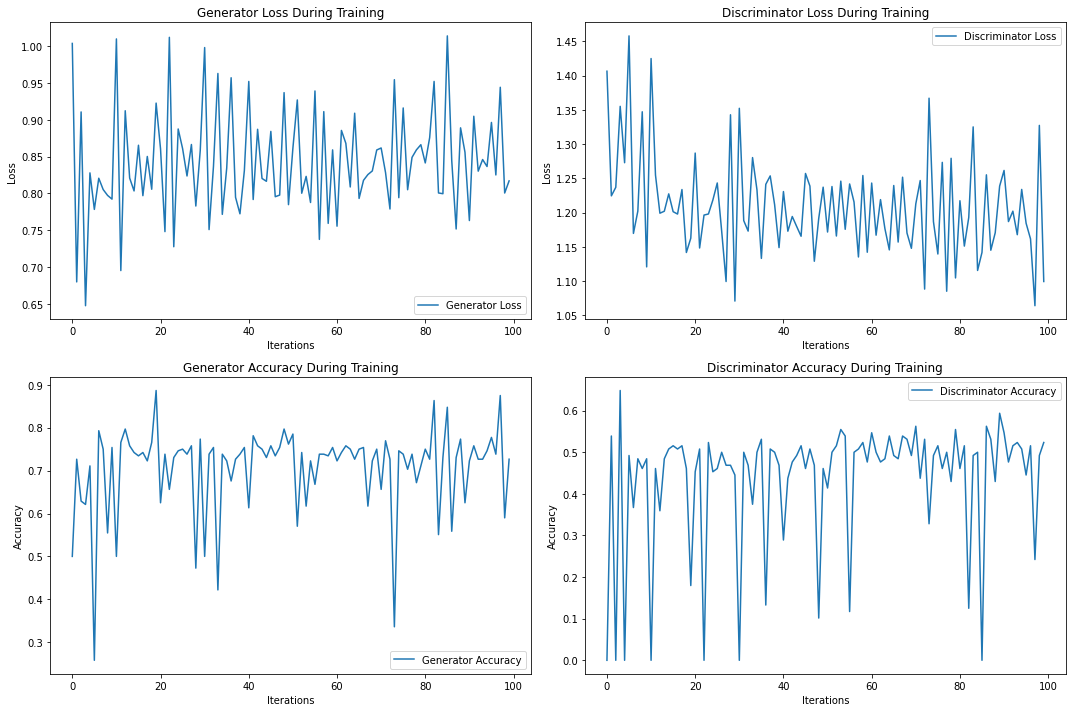

In [15]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot generator loss
axes[0, 0].plot(G_losses, label="Generator Loss")
axes[0, 0].set_xlabel("Iterations")
axes[0, 0].set_ylabel("Loss")
axes[0, 0].set_title("Generator Loss During Training")
axes[0, 0].legend()

# Plot discriminator loss
axes[0, 1].plot(D_losses, label="Discriminator Loss")
axes[0, 1].set_xlabel("Iterations")
axes[0, 1].set_ylabel("Loss")
axes[0, 1].set_title("Discriminator Loss During Training")
axes[0, 1].legend()

# Plot generator accuracy
axes[1, 0].plot(G_Accuracys, label="Generator Accuracy")
axes[1, 0].set_xlabel("Iterations")
axes[1, 0].set_ylabel("Accuracy")
axes[1, 0].set_title("Generator Accuracy During Training")
axes[1, 0].legend()

# Plot discriminator accuracy
axes[1, 1].plot(D_Accuracys, label="Discriminator Accuracy")
axes[1, 1].set_xlabel("Iterations")
axes[1, 1].set_ylabel("Accuracy")
axes[1, 1].set_title("Discriminator Accuracy During Training")
axes[1, 1].legend()

plt.tight_layout()
plt.show()

In [16]:
# generate new data point
noise = torch.randn(100, input_size)
condition = torch.randint(0, 2, (100,1))
generated_data = generator(noise, condition).detach().numpy()
# generated_data.shape
generated_data = np.concatenate((generated_data[:, :1], condition.float().numpy(), generated_data[:, 1:]), axis=1)
generated_data = scaler.inverse_transform(generated_data)
generated_data[generated_data < 0] = 0 # set negative values to 0
generated_data = np.round(generated_data).astype(int)  # round to nearest integer
generated_df = pd.DataFrame(generated_data, columns = ads.columns) # convert to dataframe
generated_df.head()

,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,...,ad_close_list_v003_1,ad_close_list_v003_2,ad_close_list_v003_3,ad_close_list_v003_4,ad_close_list_v003_5,u_newsCatInterestsST_1,u_newsCatInterestsST_2,u_newsCatInterestsST_3,u_newsCatInterestsST_4,u_newsCatInterestsST_5
0,185625,1,209967,3,2,36,211,2,29,4,...,103,15,0,110,12,46,141,79,60,42
1,141669,1,207105,3,2,35,205,2,29,4,...,98,16,0,122,15,38,143,75,56,36
2,367971,0,212761,4,2,35,224,2,27,4,...,138,5,0,72,10,70,122,88,61,71
3,328097,0,206662,4,2,34,222,2,27,4,...,132,3,0,78,8,69,119,85,60,67
4,148315,1,203130,4,2,36,196,2,28,4,...,103,18,0,109,6,46,142,77,60,34


In [17]:
generated_df.columns

Index(['log_id', 'label', 'user_id', 'age', 'gender', 'residence', 'city',
       'city_rank', 'series_dev', 'series_group', 'emui_dev', 'device_name',
       'device_size', 'net_type', 'task_id', 'adv_id', 'creat_type_cd',
       'adv_prim_id', 'inter_type_cd', 'slot_id', 'site_id', 'spread_app_id',
       'hispace_app_tags', 'app_second_class', 'app_score', 'pt_d',
       'u_refreshTimes', 'u_feedLifeCycle', 'ad_click_list_v001_1',
       'ad_click_list_v001_2', 'ad_click_list_v001_3', 'ad_click_list_v001_4',
       'ad_click_list_v001_5', 'ad_click_list_v002_1', 'ad_click_list_v002_2',
       'ad_click_list_v002_3', 'ad_click_list_v002_4', 'ad_click_list_v002_5',
       'ad_click_list_v003_1', 'ad_click_list_v003_2', 'ad_click_list_v003_3',
       'ad_click_list_v003_4', 'ad_click_list_v003_5', 'ad_close_list_v001_1',
       'ad_close_list_v001_2', 'ad_close_list_v001_3', 'ad_close_list_v001_4',
       'ad_close_list_v001_5', 'ad_close_list_v002_1', 'ad_close_list_v002_2',
       'a

In [25]:
generated_df['ad_click_list_v001'] = generated_df[['ad_click_list_v001_'+str(i+1) for i in range(5)]].astype(str).agg('^'.join, axis=1)
generated_df['ad_click_list_v002'] = generated_df[['ad_click_list_v002_'+str(i+1) for i in range(5)]].astype(str).agg('^'.join, axis=1)
generated_df['ad_click_list_v003'] = generated_df[['ad_click_list_v003_'+str(i+1) for i in range(5)]].astype(str).agg('^'.join, axis=1)
generated_df['ad_close_list_v001'] = generated_df[['ad_close_list_v001_'+str(i+1) for i in range(5)]].astype(str).agg('^'.join, axis=1)
generated_df['ad_close_list_v002'] = generated_df[['ad_close_list_v002_'+str(i+1) for i in range(5)]].astype(str).agg('^'.join, axis=1)
generated_df['ad_close_list_v003'] = generated_df[['ad_close_list_v003_'+str(i+1) for i in range(5)]].astype(str).agg('^'.join, axis=1)
generated_df['u_newsCatInterestsST'] = generated_df[['u_newsCatInterestsST_'+str(i+1) for i in range(5)]].astype(str).agg('^'.join, axis=1)

In [23]:
reference_time = pd.to_datetime('2022-06-02 01:23')
generated_df['pt_d'] = reference_time + pd.to_timedelta(generated_df['pt_d'].astype(int), unit='m')

In [26]:
get_columns = pd.read_csv('train/train_data_ads.csv', nrows = 1)
generated_df[get_columns.columns]

,log_id,label,user_id,age,gender,residence,city,city_rank,series_dev,series_group,...,ad_click_list_v001,ad_click_list_v002,ad_click_list_v003,ad_close_list_v001,ad_close_list_v002,ad_close_list_v003,pt_d,u_newsCatInterestsST,u_refreshTimes,u_feedLifeCycle
0,185625,1,209967,3,2,36,211,2,29,4,...,30602^6887^0^8735^0,1720^933^685^0^0,280^50^40^24^0,25902^0^4165^7759^0,1232^0^217^540^0,103^15^0^110^12,2022-06-04 16:23:00,46^141^79^60^42,2,12
1,141669,1,207105,3,2,35,205,2,29,4,...,30411^5764^0^8935^0,1717^911^664^0^0,277^47^33^13^0,25989^0^3603^8103^0,1225^0^247^571^0,98^16^0^122^15,2022-06-04 11:06:00,38^143^75^56^36,1,12
2,367971,0,212761,4,2,35,224,2,27,4,...,29628^11981^1280^11003^0,1612^940^811^214^114,276^61^58^43^0,24457^0^3288^5296^0,1208^0^237^404^0,138^5^0^72^10,2022-06-05 07:22:00,70^122^88^61^71,2,13
3,328097,0,206662,4,2,34,222,2,27,4,...,28519^11182^965^9837^0,1591^913^750^171^95,268^67^60^43^0,23988^0^3415^5280^0,1215^0^229^387^0,132^3^0^78^8,2022-06-05 02:00:00,69^119^85^60^67,2,13
4,148315,1,203130,4,2,36,196,2,28,4,...,30352^5793^0^7043^0,1727^900^672^0^0,280^36^32^19^0,25705^0^3795^7722^0,1246^0^183^549^0,103^18^0^109^6,2022-06-04 10:24:00,46^142^77^60^34,1,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,314983,0,215498,4,2,35,221,2,28,4,...,29971^10529^0^10522^0,1644^915^759^120^52,279^65^49^28^0,25036^0^3671^6188^0,1223^0^271^443^0,131^6^3^86^9,2022-06-05 01:11:00,66^131^90^59^64,2,13
96,329098,0,207808,4,2,34,216,2,27,4,...,29259^10948^0^9012^0,1623^897^729^112^45,273^56^55^40^0,24331^0^3784^5532^0,1226^0^212^411^0,128^6^0^74^5,2022-06-05 00:54:00,69^123^86^62^64,2,13
97,219680,0,201753,4,2,35,206,2,27,4,...,29123^8132^0^8234^0,1658^895^706^0^0,272^48^44^30^0,24780^0^3647^6766^0,1227^0^200^463^0,115^13^0^94^6,2022-06-04 16:54:00,56^130^81^59^48,2,13
98,214804,0,209980,4,2,35,205,2,28,4,...,30111^7432^0^9307^0,1688^878^654^0^0,281^53^34^13^0,25670^0^3616^7385^0,1223^0^268^490^0,116^14^0^106^11,2022-06-04 15:04:00,54^138^83^56^49,2,13
